In [1]:
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.image import imread
import torchvision as tv
import numpy as np
from PIL import Image

sys.path.append('../../../')

from core.datasets import get_ds

In [2]:
train_ds, *ds = get_ds('repaired_data_train', 'repaired_data_test', batch_size=20, back=3)
images, labels = train_ds[3]

In [3]:
def draw_aug_ds(transformer):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        name = labels[i]
        if transformer is not None:
            img = np.array(transformer(Image.fromarray((images[i] * 255).astype(np.uint8), 'RGB')))
        else:
            img = images[i] * 255
        plt.imshow(img / 255, cmap=plt.cm.binary)
        plt.title(name)
        plt.axis('off')
    plt.show()

----
## Голые данные

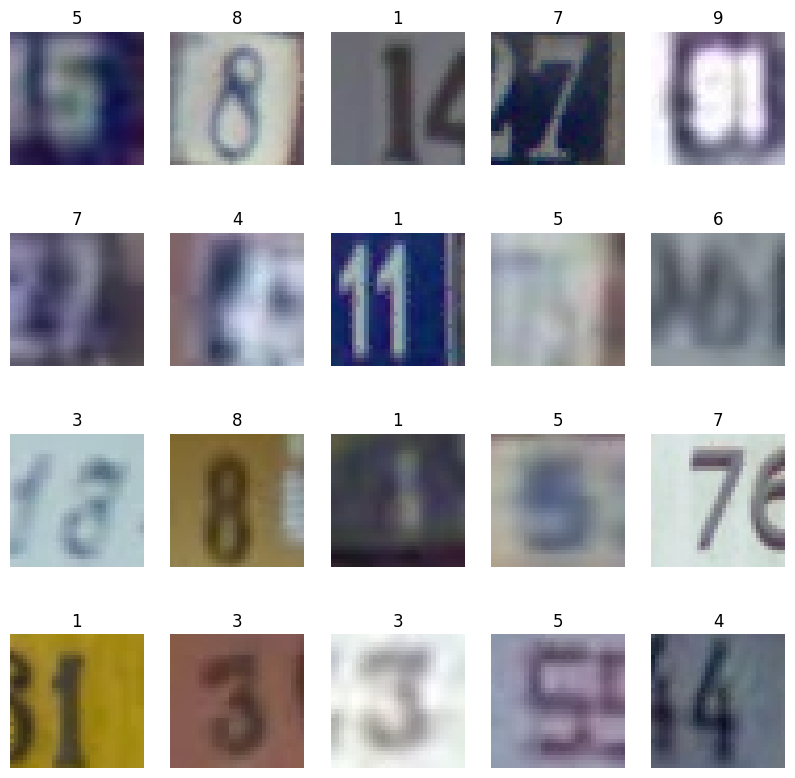

In [4]:
draw_aug_ds(None)

----
## Pad
- Расширяет границы изображения, добавляя "рамки"

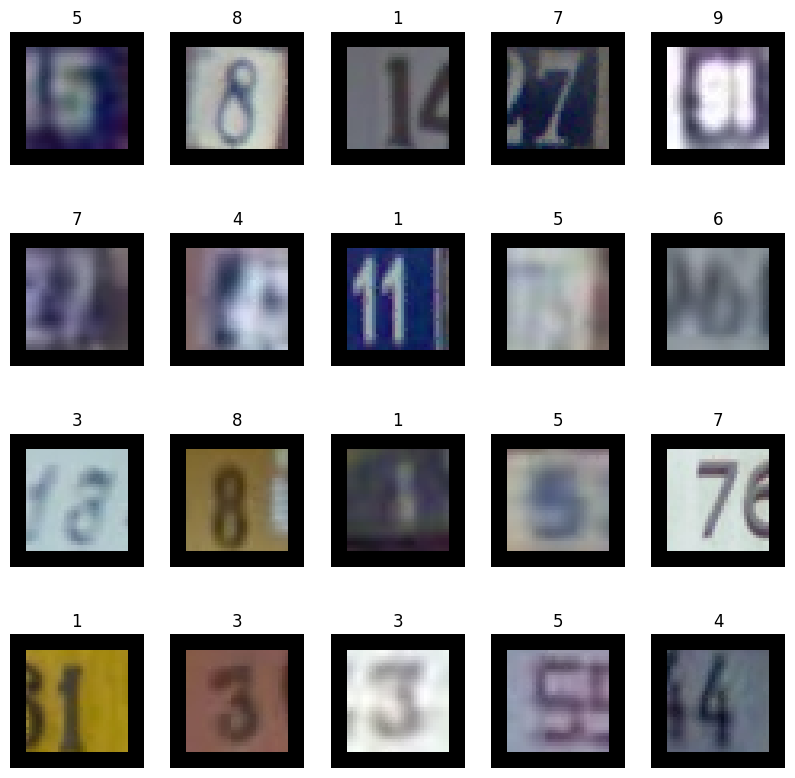

In [5]:
padding = tv.transforms.Pad(padding=5)
draw_aug_ds(padding)

Данные сосредоточены в центре, использовать не будем.

----
## Resize
- Изменяет размер изображения.

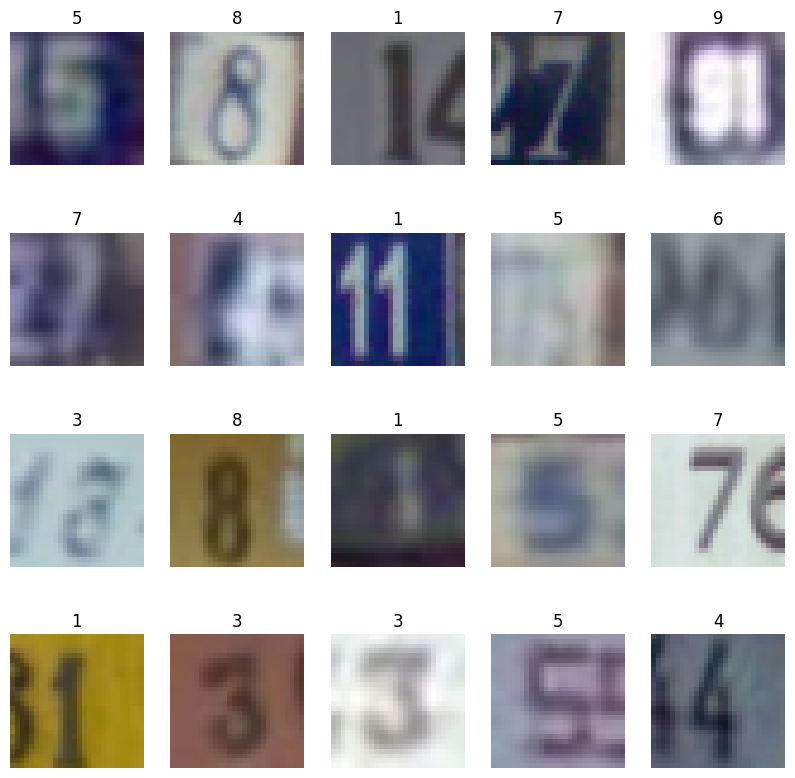

In [6]:
resize = tv.transforms.Resize(size=28)
draw_aug_ds(resize)

Практически бессмысленно уменьшать картинки, они и так маленькие. Увеличение картинки может помочь, но сильно затруднит процесс обучения

----
## CenterCrop
- Обрезает заданное изображение по центру.

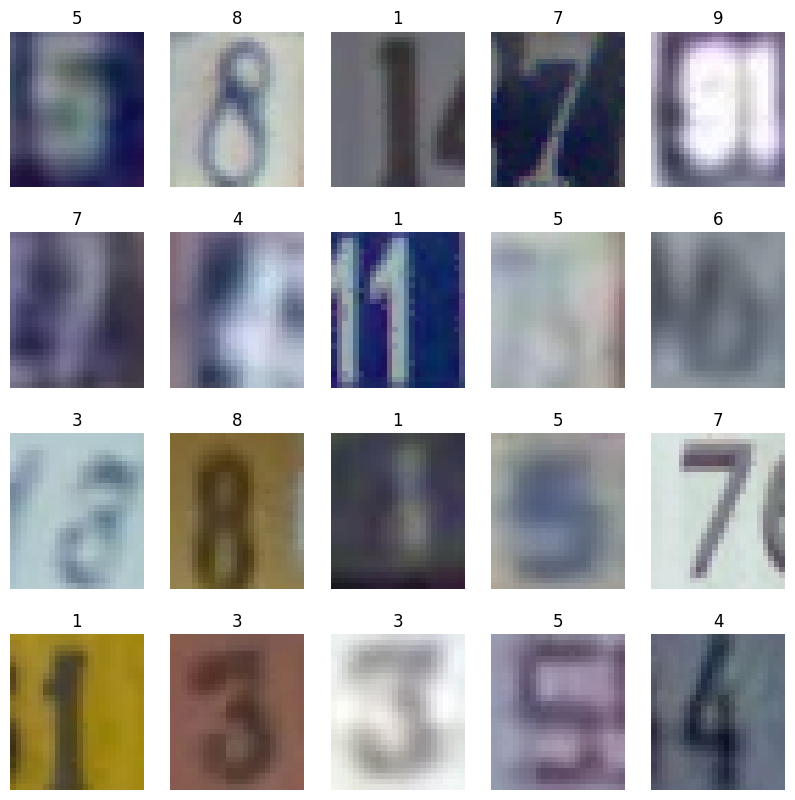

In [7]:
center_crop = tv.transforms.CenterCrop(size=(28, 24))
draw_aug_ds(center_crop)

Обрезает ненужные части картинки, хороший метод

----
## FiveCrop
- Обрезает изображение по 4 углам и центру

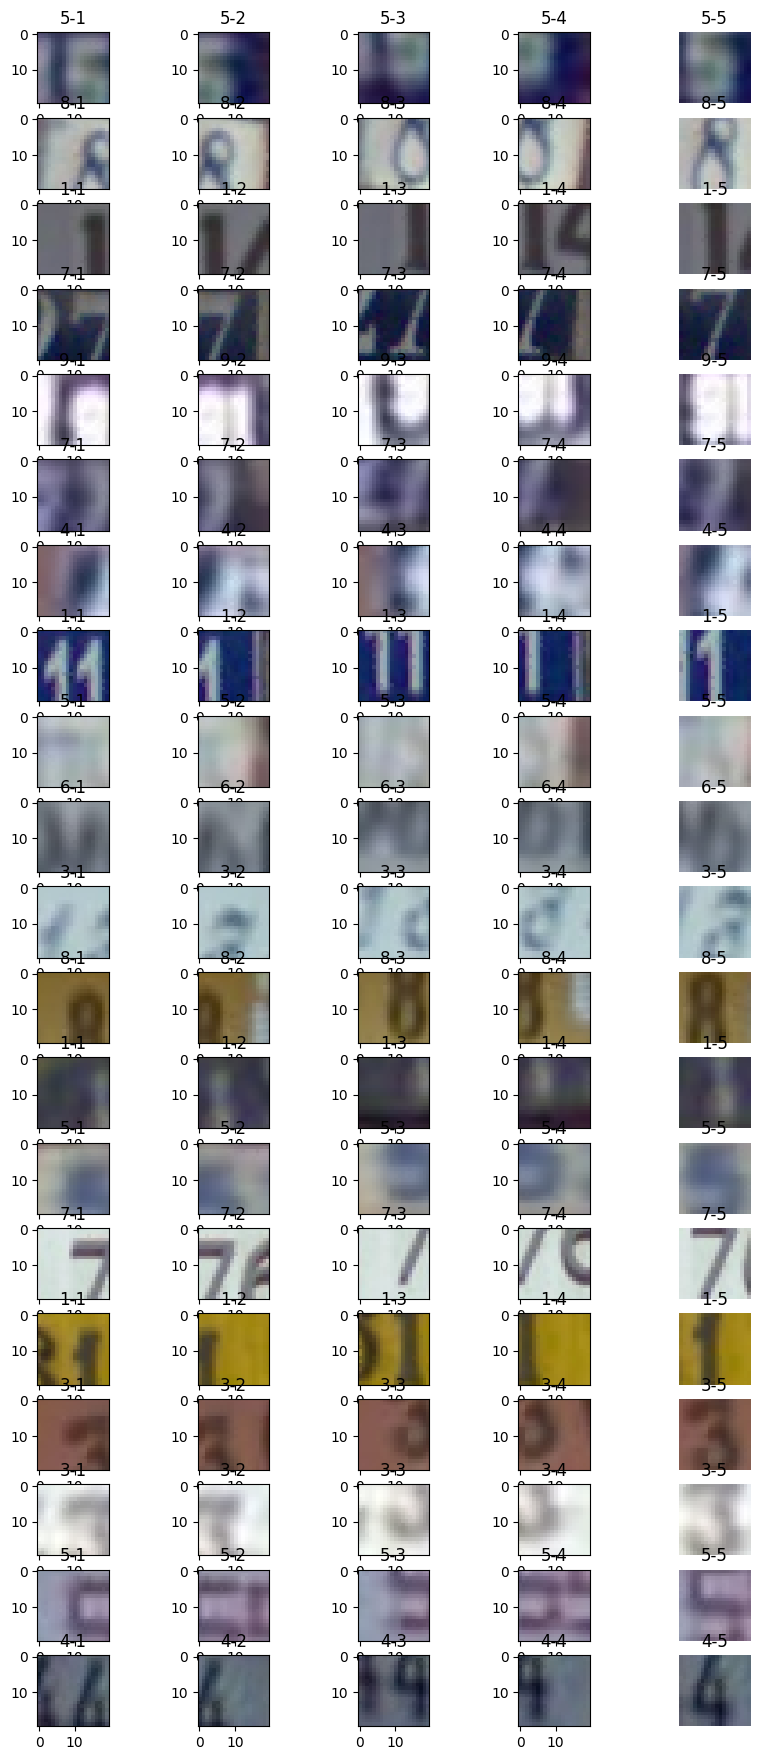

In [8]:
five_crop = tv.transforms.FiveCrop(size=(20, 20))
plt.figure(figsize=(10, 22))
c = 0
for i in range(20):
    imgs = five_crop(Image.fromarray((images[i] * 255).astype(np.uint8), 'RGB'))
    im_c = 1
    for im in imgs:
        plt.subplot(20, 5, c + 1)
        plt.imshow(np.array(im), cmap=plt.cm.binary)
        name = labels[i]
        plt.title(f'{name}-{im_c}')
        c += 1
        im_c += 1
    plt.axis('off')
plt.show()

Не вижу применения этой аугментации на данном датасете, нет никакой связи между фотографиями

----
## Grayscale
- Преобразует изображение в оттенки серого

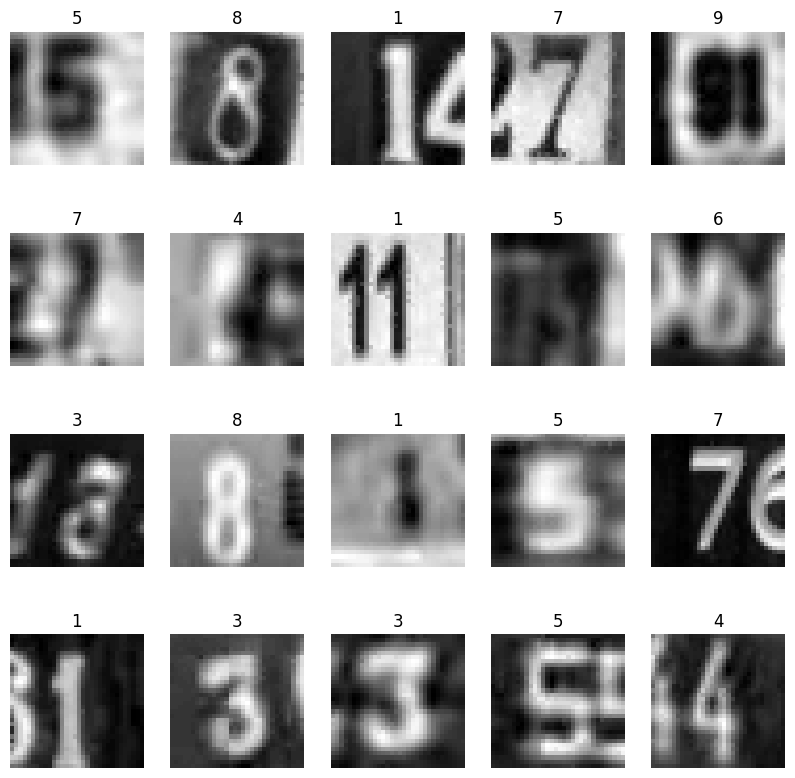

In [9]:
gray_scale = tv.transforms.Grayscale()
draw_aug_ds(gray_scale)

GrayScale'р позволяет довольно чётко определять, где находится текст, а где фон изображения, обязательно стоит попробовать применить

----
## ColorJitter
- Случайным образом изменяет яркость, насыщенность и другие свойства изображения.

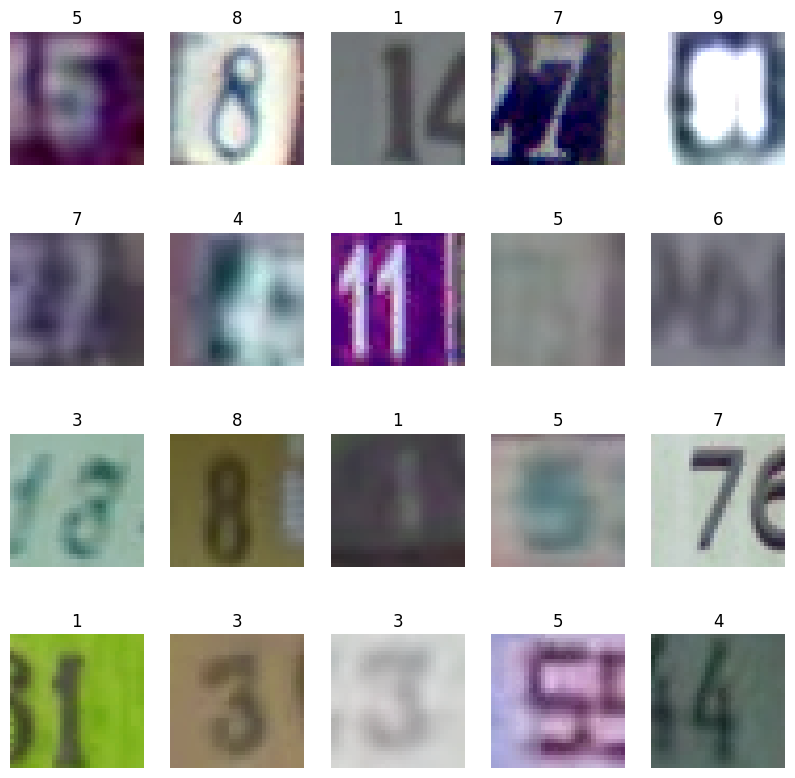

In [10]:
jitter = tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5)
draw_aug_ds(jitter)

Как и GrayScale, позволяет различать фон и надписи. Стоит попробовать

----
## GaussianBlur
- Выполняет преобразование размытия по Гауссу на изображении.

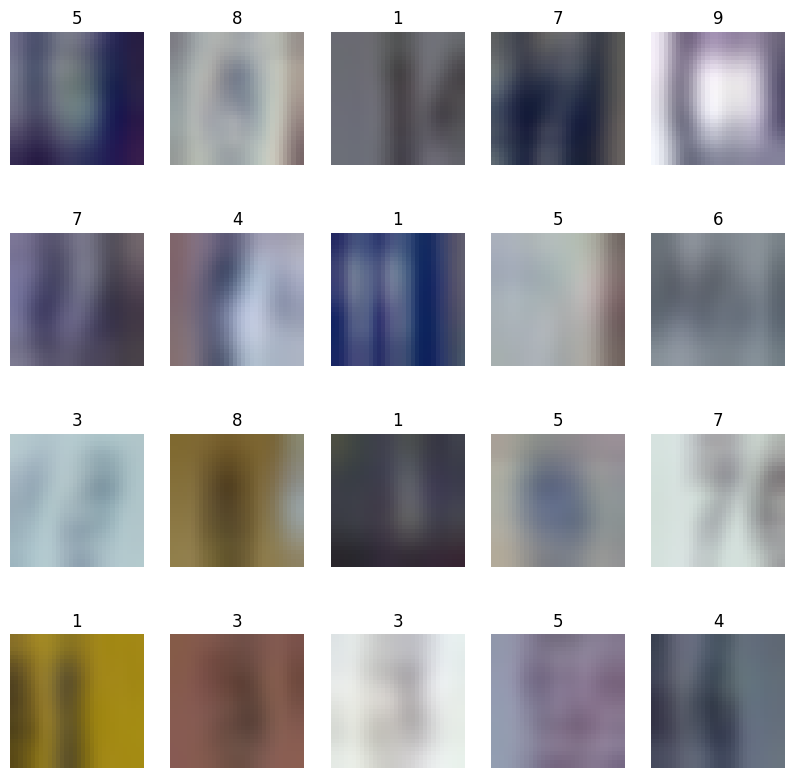

In [11]:
blurrer = tv.transforms.GaussianBlur(kernel_size=(7, 13), sigma=(9, 11))
draw_aug_ds(blurrer)

Фотография делается почти однотонной, что будет делать предсказание менее точным

----
## RandomPerspective
- Выполняет случайное преобразование перспективы изображения.

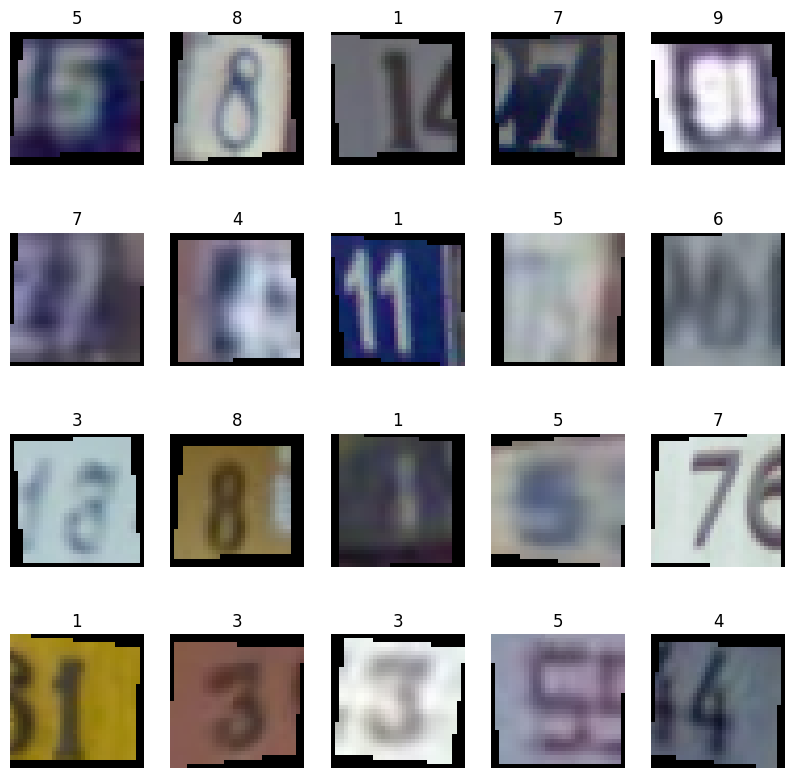

In [12]:
perspective_transformer = tv.transforms.RandomPerspective(distortion_scale=0.2, p=1.0)
draw_aug_ds(perspective_transformer)

Шрифт изображений похож, модель может обучиться лучше, следует проверять

----
## RandomRotation
- Поворачивает изображение на случайный угол.

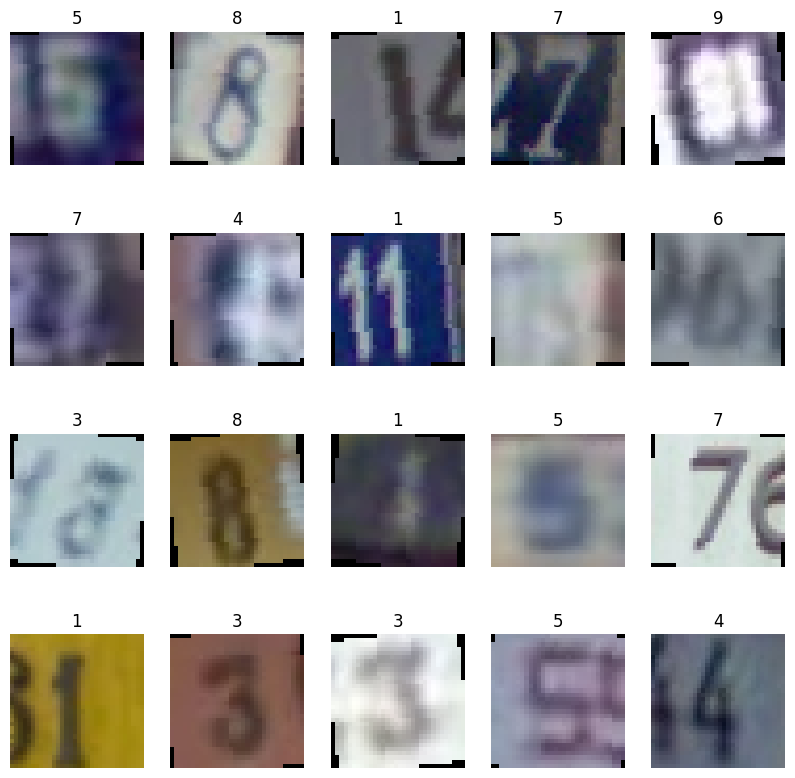

In [13]:
rotater = tv.transforms.RandomRotation(degrees=(-10, 10))
draw_aug_ds(rotater)

Аналогично с RandomPerspective, стоит проверить

----
## ElasticTransform
- Случайным образом преобразует и создает эффект прозрачности, подобный воде.

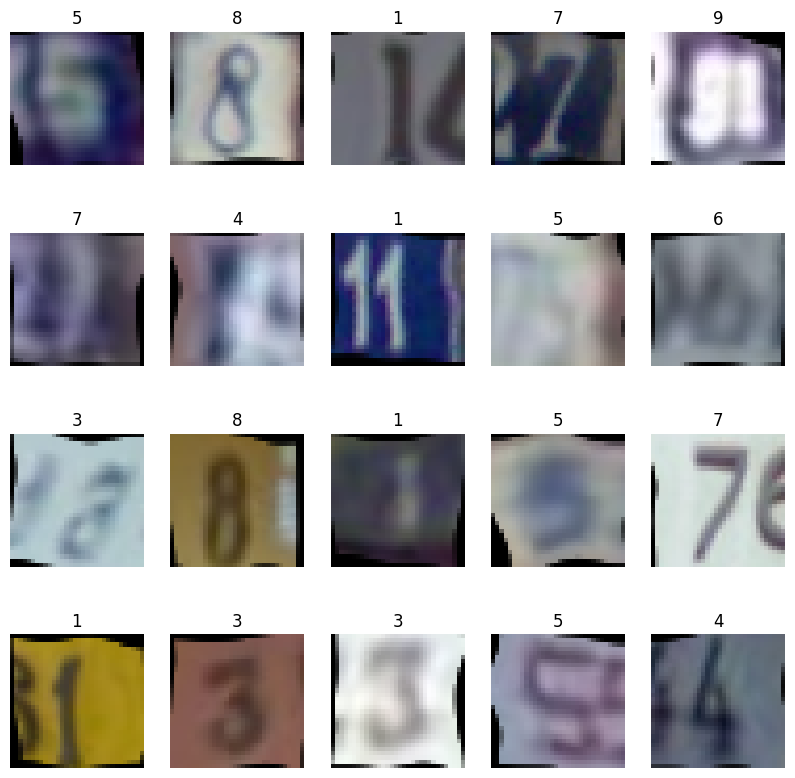

In [14]:
elastic_transformer = tv.transforms.ElasticTransform(alpha=50.)
draw_aug_ds(elastic_transformer)

Не вижу применения, после ElasticTransform цифры могут стать похожими на другие цифры, модель может обучиться неправильно

----
## RandomCrop
- Обрезает изображение в случайном месте.

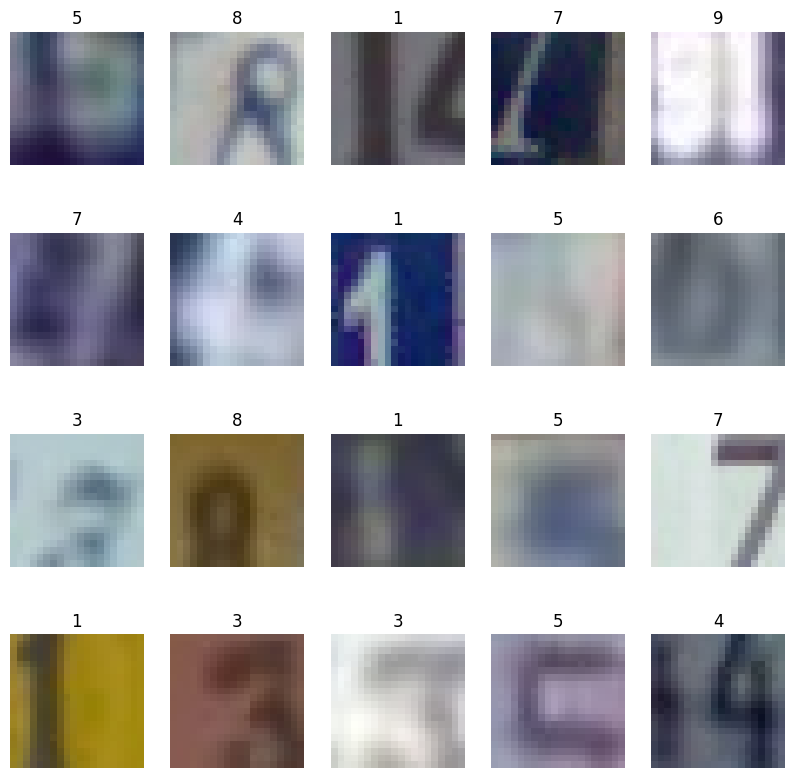

In [15]:
cropper = tv.transforms.RandomCrop(size=(20, 20))
draw_aug_ds(cropper)

В кадре может почти не оказаться цифры, фичи теряются, этот вариант плохой

----
## RandomResizedCrop
- Обрезает изображение в случайном месте, а затем изменяет размер до заданного.

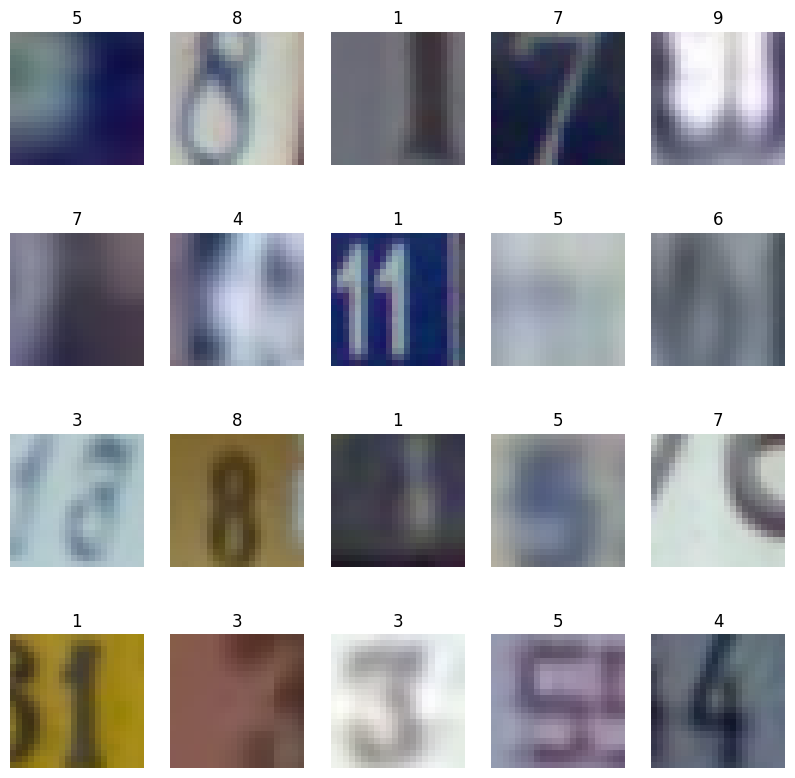

In [16]:
resize_cropper = tv.transforms.RandomResizedCrop(size=(22, 22))
draw_aug_ds(resize_cropper)

Картинки маленькие + crop будет мешать модели(картинки не будет в кадре)

----
## RandomInvert
- Случайным образом инвертирует цвета данного изображения.

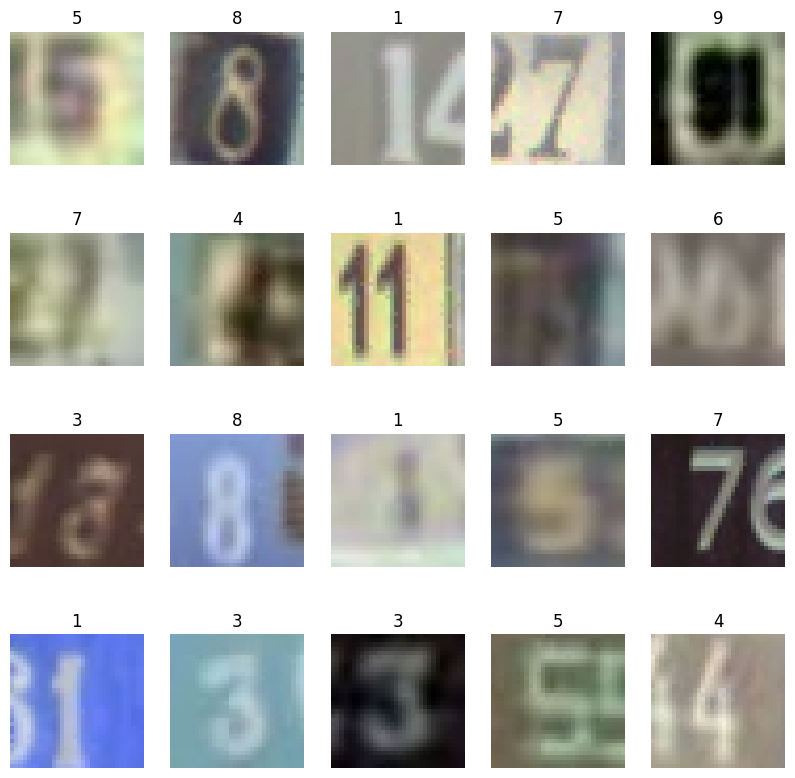

In [17]:
inverter = tv.transforms.RandomInvert(p=1)
draw_aug_ds(inverter)

Хороший вариант смены контраста, стоит попробовать

----
## RandomPosterize
- Случайным образом постерирует изображение, уменьшая количество битов в каждом цветовом канале.

Явление постеризации возникает тогда, когда битовая глубина изображения уменьшается настолько, что это определяется визуально. Термин постеризация используется потому, что при этом цвета изображения становятся похожи на типографские плакаты, при печати которых используется ограниченное количество цветных чернил.

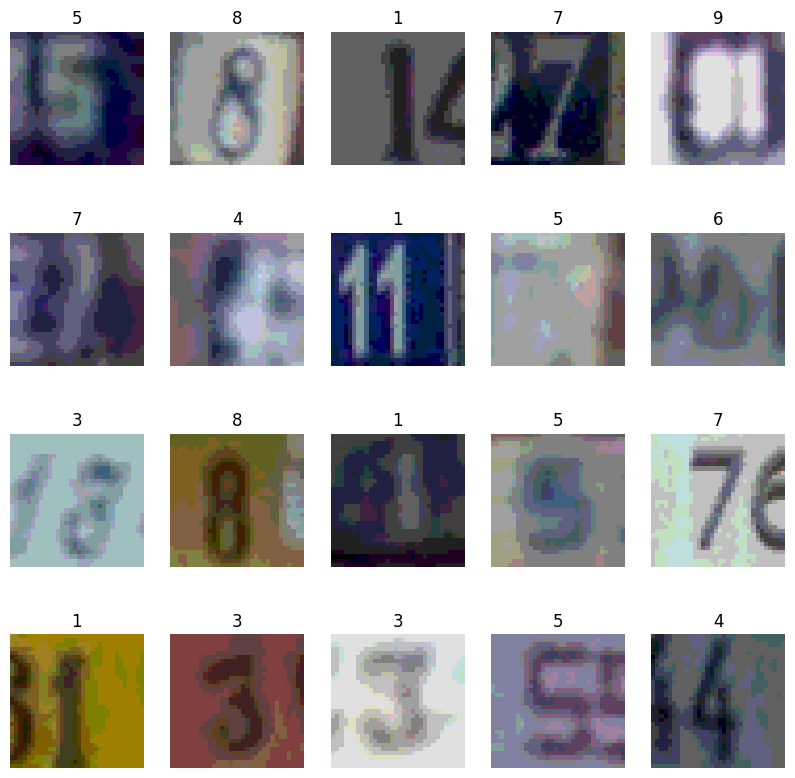

In [18]:
posterizer = tv.transforms.RandomPosterize(bits=3, p=1)
draw_aug_ds(posterizer)

Также следует протестировать, отделяет фон от номера

----
## RandomSolarize
- Случайным образом соляризует изображение путем инвертирования всех значений пикселей, превышающих пороговое значение.

Соляризацией называется вторичное экспонирование фото-бумаги во время проявления.

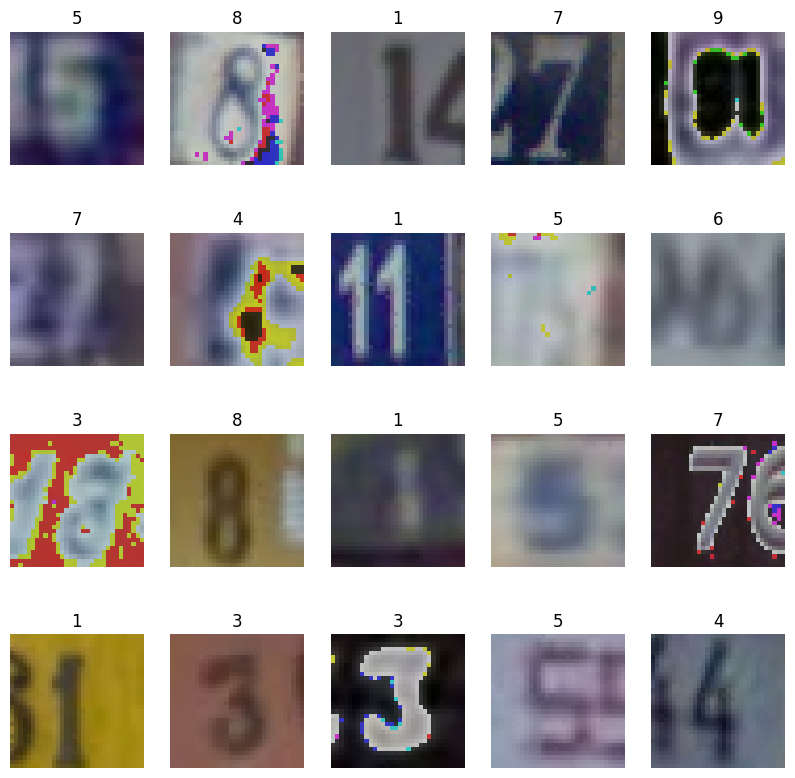

In [19]:
solarizer = tv.transforms.RandomSolarize(threshold=200.0, p=1)
draw_aug_ds(solarizer)

Для такого датасета данный вид аугментации должен быть не плох, но как видно, некоторые цифры он превращает в абсолютно другие, надо смотреть на результаты модели

----
## RandomAdjustSharpness
- Случайным образом регулирует резкость данного изображения.

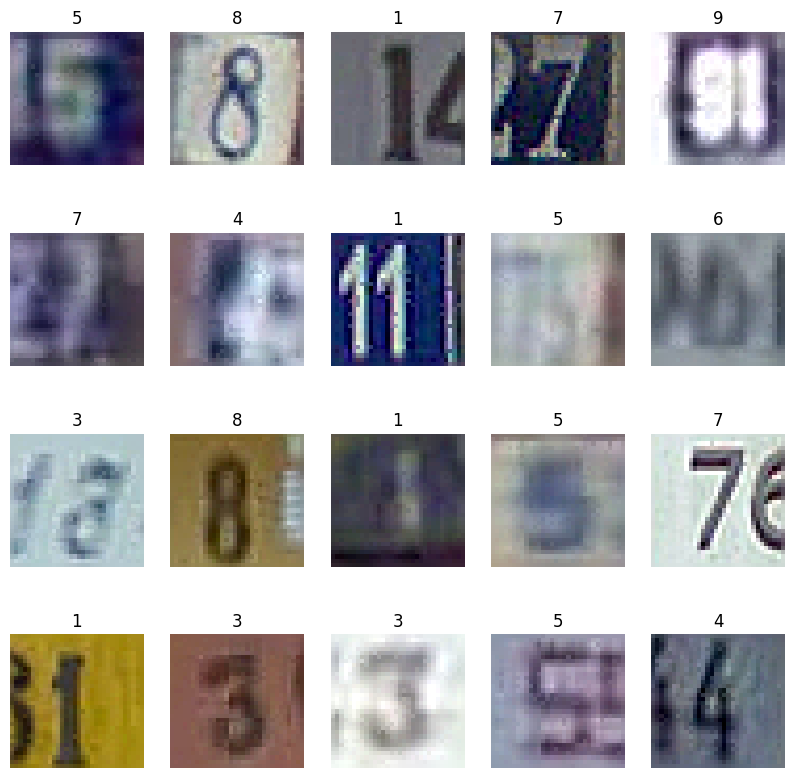

In [20]:
sharpness_adjuster = tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=1)
draw_aug_ds(sharpness_adjuster)

Резкость увеличивается, но фиги теряются, плохой метод

----
## RandomAutocontrast
- Cлучайным образом применяет контраст к данному изображению.

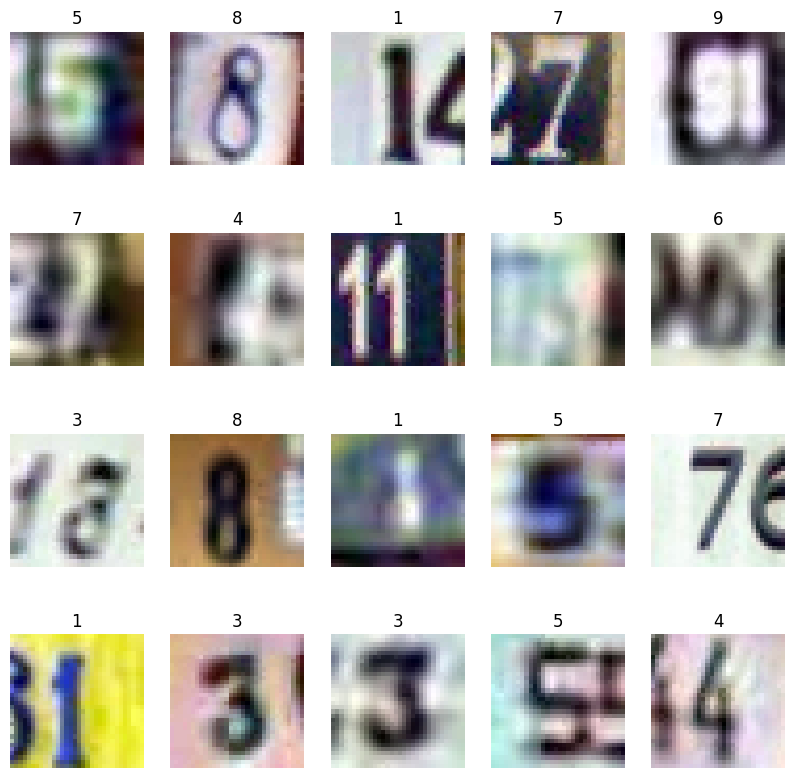

In [21]:
autocontraster = tv.transforms.RandomAutocontrast(p=1)
draw_aug_ds(autocontraster)

Картинки почти не меняются. -

----
## RandomEqualize
- Случайным образом выравнивает гистограмму данного изображения.

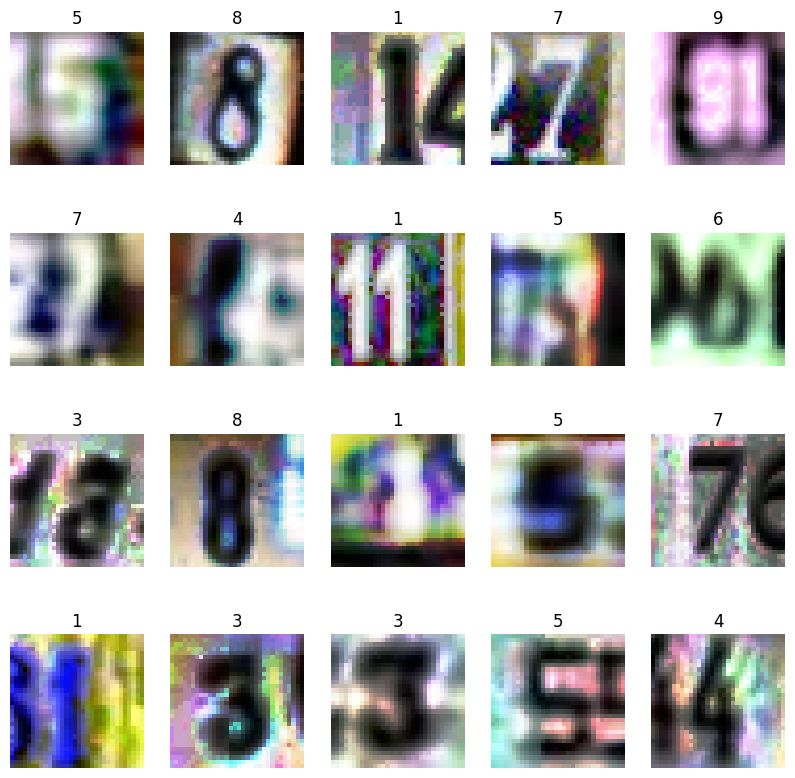

In [22]:
equalizer = tv.transforms.RandomEqualize(p=1)
draw_aug_ds(equalizer)

Следует обратить внимание, контраст увеличивается

----
## RandomHorizontalFlip
- Выполняет горизонтальный переворот изображения с заданной вероятностью.

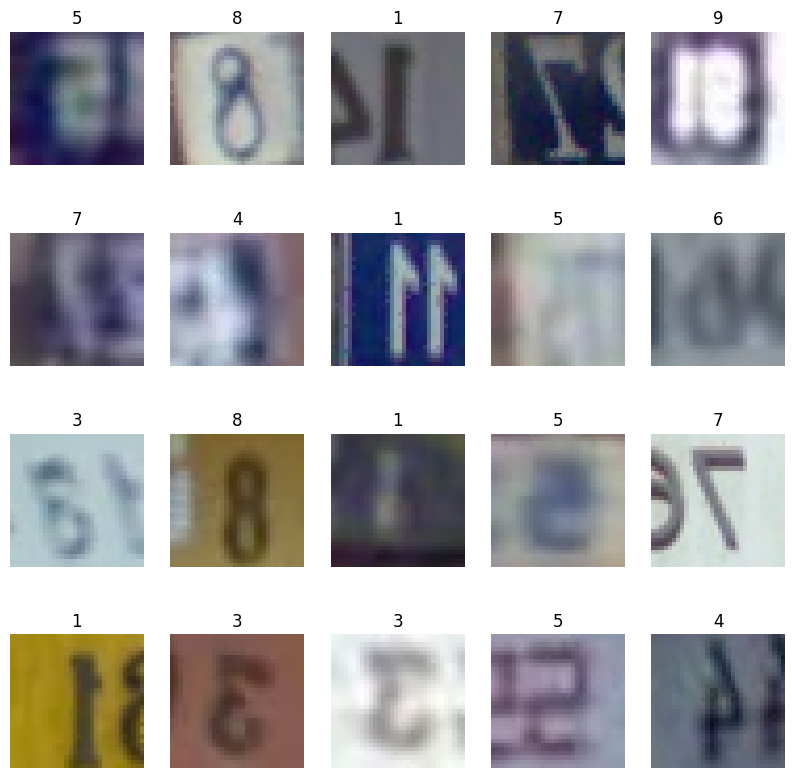

In [23]:
hflipper = tv.transforms.RandomHorizontalFlip(p=1)
draw_aug_ds(hflipper)

цифры пишутся абсолютно иначе, будет мешать модели

----
## RandomVerticalFlip
- Выполняет вертикальный переворот изображения с заданной вероятностью.

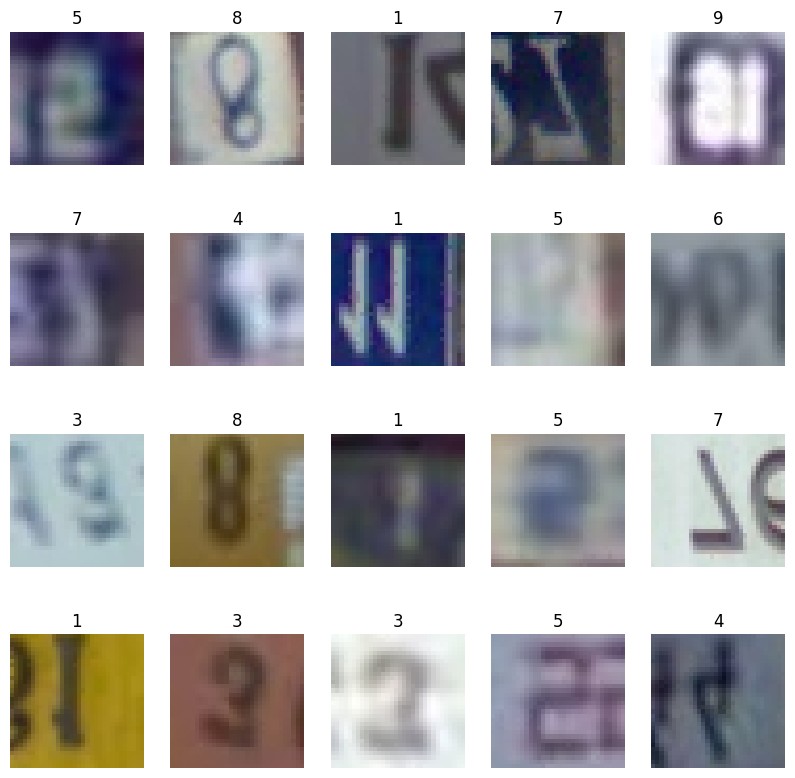

In [24]:
vflipper = tv.transforms.RandomVerticalFlip(p=1)
draw_aug_ds(vflipper)

Аналогично горизонтальному повороту суть изображения меняется

----
## RandomAffine
- Поворачивает картинку, смещает её и изменяет размер

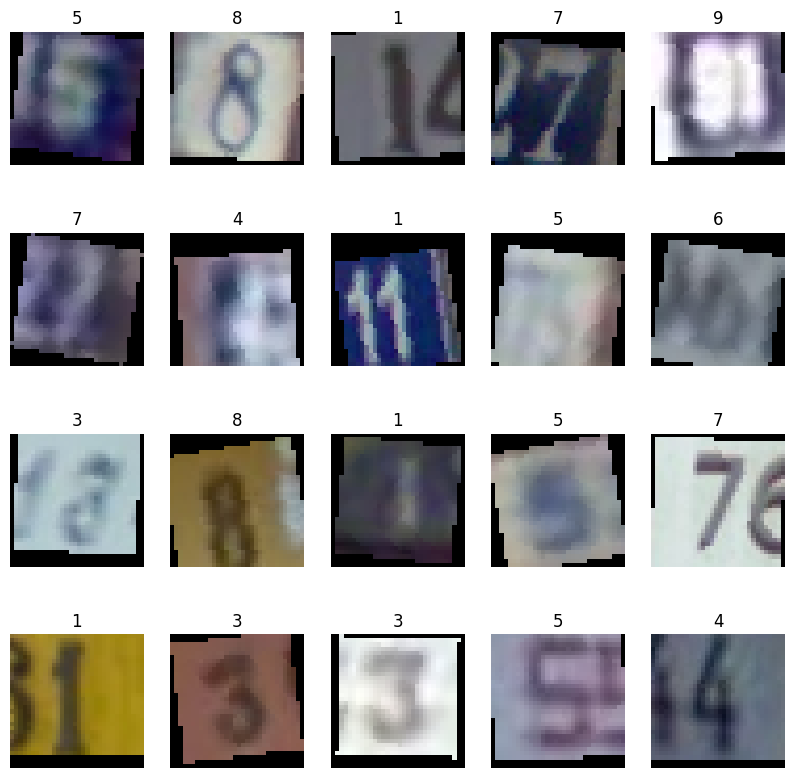

In [25]:
affine = tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1))
draw_aug_ds(affine)

## Вывод:
Для таких данных важно:
- увеличить контрастность
- увеличить вариативность данных
- уменьшить размер картинки


С пунктом 1 хорошо помогают следующие способы:
1. ColorJitter
2. RandomInvert
3. RandomPosterize

Следующие методы тоже хорошие, но теряют некоторые фичи, следует тоже проверить:
1. RandomSolarize
2. RandomEqualize
3. Grayscale

С пунктом 2 помогут аугментации:
1. RandomPerspective
2. RandomRotation
3. RandomAffine

С пунктом 3 помогает:
1. CenterCrop

доработки:
1. попробовать на моделях делать обрезку по краям
2. для одной модели разные варианты комбинаций аугментаций
```python
transformer1 = tv.transforms.Compose([
    tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=.4),
    tv.transforms.RandomHorizontalFlip(),
])
transformer2 = tv.transforms.Compose([
    tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=.4),
    tv.transforms.RandomHorizontalFlip(),
])
transformer3 = tv.transforms.Compose([
    tv.transforms.RandomAdjustSharpness(sharpness_factor=5, p=.4),
    tv.transforms.RandomHorizontalFlip(p=.5),
])
get_ds(transform=[tr1, tr2, tr3])
```